# Histhopathologic Cancer Detection Project

**Project Goal:** Use Convolutional Neural Networks to classify images of pathology scans as whether they have cancer or not. 

Dataset: Histhopathologic Cancer Detection

Citation: Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle.

Github: 


**The Challenge:** We are given a dataset with small inputs from large digital pathalogy scans that we must correctly identify as containing cancer or not. It is a binary classification problem where 0 labels are indicating no cancer while 1 labels indicates cancer. The images are 96x96 in size. A positive label indicates that the center region(32x32) contains at least one pixel of tumor tissure. Tumor tissue in the outer layer does not influence the label. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


**Dataset:** This dataset contains 220025 samples and each sample is a microscopic image of lymph node tissue. 

This notebook will be using **Convolutional Neural Networks** to classify images into whether they have cancer or not. 

In [2]:
print(df.shape)

(220025, 2)


In [3]:
import matplotlib.pyplot as plt
import random
from PIL import Image
from sklearn.metrics import classification_report


# Exploratory Data Analysis

In this section we will try to understand the dataset better before setting up our model.

Text(0, 0.5, 'Samples')

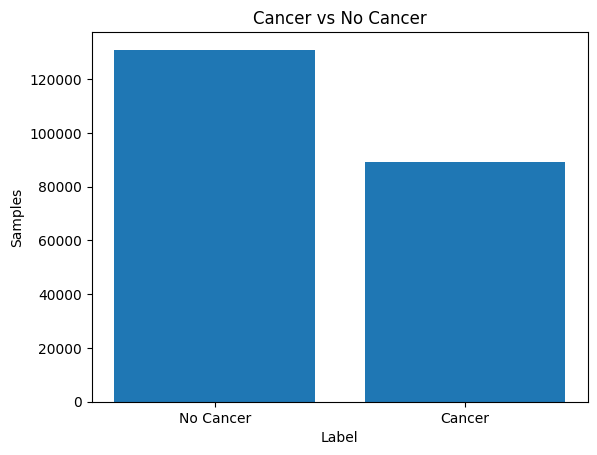

In [4]:
counts = df['label'].value_counts()
plt.bar(["No Cancer", "Cancer"], counts)
plt.title("Cancer vs No Cancer")
plt.xlabel("Label")
plt.ylabel("Samples")

There are more No cancer samples than Cancer samples in this dataset. Since the dataset is fairly large using a subset from each class would be more appropriate for training our CNN model. 

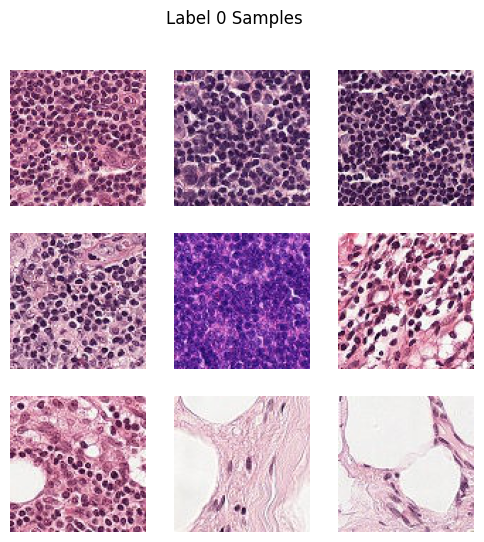

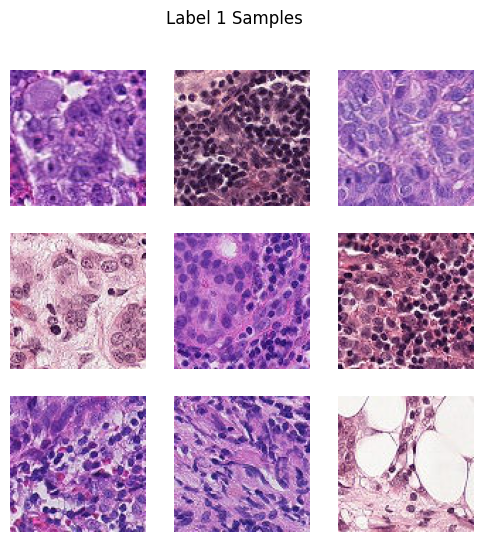

In [5]:
def plot_images(df, label, num_images=9):
    sample_ids = df[df['label'] == label].sample(num_images)['id'].values
    plt.figure(figsize=(6,6))
    for i, img_id in enumerate(sample_ids):
        img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{img_id}.tif"
        img = Image.open(img_path)
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"Label {label} Samples")
    plt.show()

plot_images(df, label=0)
plot_images(df, label=1)

Here we can assess the differences visually between images with no cancer and images with cancer. Label 0 are images with no cancer and Label 1 are images with cancer. Some things I noticed were the big white spots that may be tumors in the cancer labeled images but I am not so sure. It is hard to distinguish clearly what makes the cancer noticeable in these images. 

In [6]:
import numpy as np

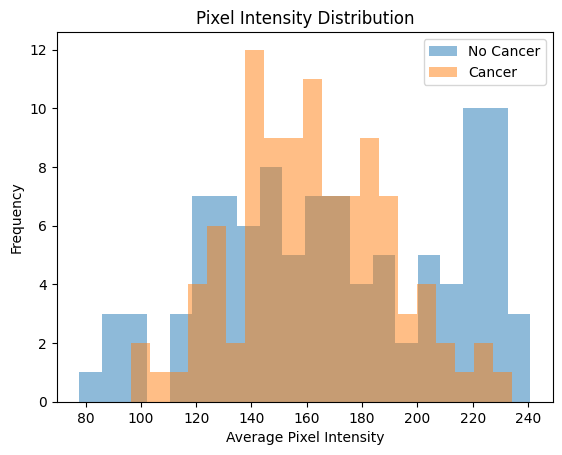

In [7]:
def get_avg_intensity(label):
    sample_ids = df[df['label'] == label].sample(100)['id'].values
    intensities = []
    for img_id in sample_ids:
        img = Image.open(f"/kaggle/input/histopathologic-cancer-detection/train/{img_id}.tif")
        img_arr = np.array(img)
        intensities.append(img_arr.mean())
    return intensities

no_cancer_intensity = get_avg_intensity(0)
cancer_intensity = get_avg_intensity(1)

plt.hist(no_cancer_intensity, bins=20, alpha=0.5, label='No Cancer')
plt.hist(cancer_intensity, bins=20, alpha=0.5, label='Cancer')
plt.xlabel('Average Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.title('Pixel Intensity Distribution')
plt.show()

By assessing the average pixel density per class we can compare differences in pixel distribution. The model may use this data when trying to classify images on pixel density rather than what actually determines an image with cancer. Here the cancer labeled images spike in the middle but are fairly spread out simalar to the non-cancer labeled images which are higher on the low and high average pixel intensity axis. 

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten,Dense, Dropout, BatchNormalization)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [9]:
img_path = "/kaggle/input/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif"
img = Image.open(img_path)
print("Size:", img.size)

Size: (96, 96)


# Data Preprocessing

In this step we will use a sample size of 10000. The model is time extensive and cannot process the entire dataset efficiently so using a subsample with equal parts from both labels can help with efficiency. 

In [10]:
sample_size = 10000
df0 = df[df['label'] == 0].sample(sample_size, random_state = 42)
df1 = df[df['label'] == 1].sample(sample_size, random_state = 42)

df_subset = pd.concat([df0, df1]).sample(frac=1, random_state=42).reset_index(drop = True)


Using sklearn's train_test_split function we can create a train dataframe and a validation dataframe.

In [11]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df_subset,
    test_size=0.2,
    stratify=df_subset['label'],
    random_state=42
)


In [12]:
from tqdm import tqdm

In [13]:
def load_images(df, img_dir, target_size=(96, 96)):
    X = []
    y = []
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Loading images"):
        img_path = f"{img_dir}/{row['id']}.tif"
        img = Image.open(img_path).resize(target_size)
        X.append(np.array(img))
        y.append(row['label'])
    return np.array(X), np.array(y)

X_train, y_train = load_images(train_df, "/kaggle/input/histopathologic-cancer-detection/train")
X_val, y_val = load_images(val_df, "/kaggle/input/histopathologic-cancer-detection/train")

Loading images: 100%|██████████| 4000/4000 [00:35<00:00, 111.77it/s]


In [14]:
X_train = X_train / 255.0
X_val = X_val / 255.0

# Model Building

This first model is a CNN for binary classification. Starts with 96x96 images and consists of two convolutional and pooling layers for feature extraction. The model is trained with the Adam optimizer. Then layer and dropout with sigmoid activation function. The model is evaluated using AUC metrics. 

In [15]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)), MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,984,577 (15.20 MB)

 Trainable params: 3,984,577 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

This model begins with a 2D convolutional layer that applies 32 filters to the input images. Then a Max pooling layer to half the spatial size. Then a second convolutional layer with another max pooling layer. Then it is flattened to a 1D vector and a large dence layer with 128 neurons to process the extracted features. Then followed by a dropout layer and a single neuron dense output layer. The convolutional layers recognize simple patterns and the filters allow the model to look closely at each block. Pooling layers reduces noise by downsampling the image size after each convolution. 

Using early stopping based on validation loss we can prevent overfitting. There are 20 epochs and the batch size is 32.

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 129s 254ms/step - accuracy: 0.5833 - auc: 0.6147 - loss: 0.7109 - val_accuracy: 0.7610 - val_auc: 0.8405 - val_loss: 0.5498
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 116s 232ms/step - accuracy: 0.7140 - auc: 0.7609 - loss: 0.5733 - val_accuracy: 0.7765 - val_auc: 0.8580 - val_loss: 0.4802
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 230ms/step - accuracy: 0.7913 - auc: 0.8645 - loss: 0.4629 - val_accuracy: 0.7648 - val_auc: 0.8570 - val_loss: 0.4871
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 233ms/step - accuracy: 0.8068 - auc: 0.8821 - loss: 0.4334 - val_accuracy: 0.7690 - val_auc: 0.8512 - val_loss: 0.4839
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 117s 233ms/step - accuracy: 0.8267 - auc: 0.9006 - loss: 0.4004 - val_accuracy: 0.7745 - val_auc: 0.8574 - val_loss: 0.4775
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 123s 246ms/step - accuracy: 0.8475 - auc: 0.9226 - loss: 0.3552 - val_accuracy: 0.7742 - val_auc: 0.8470 - val_loss: 0.5287
Epoch 7/20
500/5

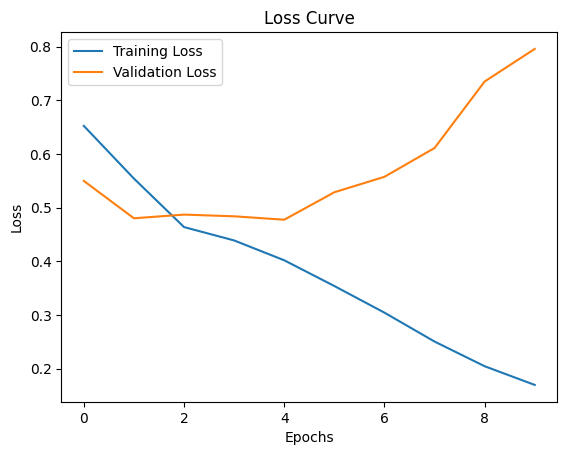

In [17]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Based on the graph the loss on validation set becomes higher meaning it starts to overfit. It works well on the training data as it continues to lower. 

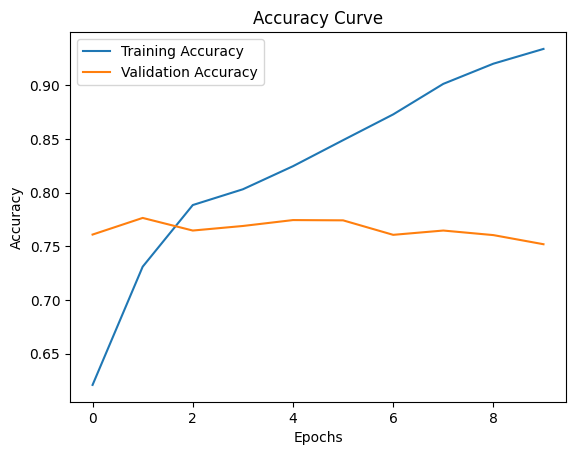

In [18]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [19]:
y_pred_probs = model.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int)
print(classification_report(y_val, y_pred))

125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step
              precision    recall  f1-score   support

           0       0.76      0.79      0.78      2000
           1       0.78      0.76      0.77      2000

    accuracy                           0.77      4000
   macro avg       0.77      0.77      0.77      4000
weighted avg       0.77      0.77      0.77      4000



In [20]:
import cv2

The architecture of the following model is fairly similar to the first but with more layers. This is a deeper CNN that uses four convolutional layers and introduces Batch Normalization for faster convergence. The model also is trained using the Adam optimizer but with a lower learning rate for more stable convergence and to prevent divergence. By adding more layers the model can learn more complex patters and better identify irregularities. 

In [21]:
model2 = Sequential([
    Input(shape=(96, 96, 3)),

    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model2.compile(optimizer= Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'auc'])

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 94, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 914,881 (3.49 MB)

 Trainable params: 913,921 (3.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [22]:
early_stopping2 = EarlyStopping(monitor ="val_loss", patience = 10, restore_best_weights=True)

history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    callbacks=[early_stopping2]
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 271s 535ms/step - accuracy: 0.7231 - auc: 0.7906 - loss: 0.6453 - val_accuracy: 0.6510 - val_auc: 0.7940 - val_loss: 0.9725
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 281s 562ms/step - accuracy: 0.8014 - auc: 0.8816 - loss: 0.4361 - val_accuracy: 0.8200 - val_auc: 0.8986 - val_loss: 0.4053
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 265s 530ms/step - accuracy: 0.8288 - auc: 0.9051 - loss: 0.3948 - val_accuracy: 0.8282 - val_auc: 0.9065 - val_loss: 0.3920
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 277s 553ms/step - accuracy: 0.8430 - auc: 0.9164 - loss: 0.3699 - val_accuracy: 0.8207 - val_auc: 0.9030 - val_loss: 0.4018
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 305s 520ms/step - accuracy: 0.8591 - auc: 0.9344 - loss: 0.3294 - val_accuracy: 0.8310 - val_auc: 0.9156 - val_loss: 0.3818
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 274s 549ms/step - accuracy: 0.8693 - auc: 0.9441 - loss: 0.3034 - val_accuracy: 0.8230 - val_auc: 0.9057 - val_loss: 0.4063
Epoch 7/20
500/5

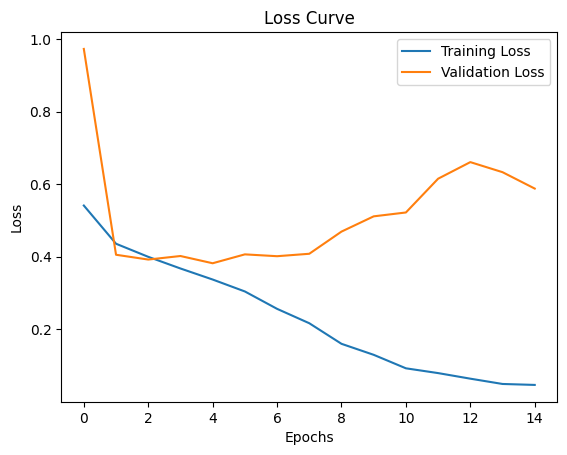

In [23]:
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

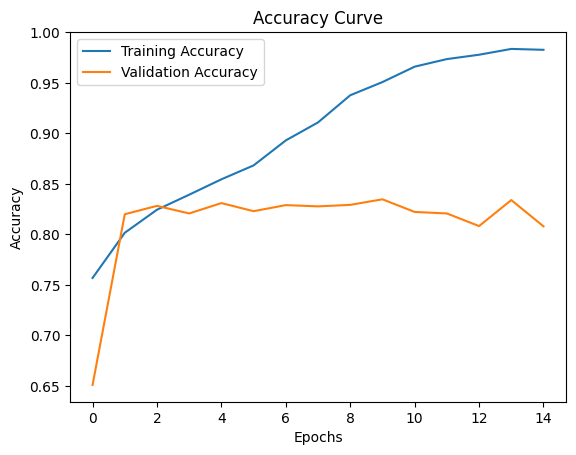

In [24]:
plt.plot(history2.history['accuracy'], label='Training Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [25]:
y_pred_probs = model2.predict(X_val)
y_pred = (y_pred_probs > 0.5).astype(int)
print(classification_report(y_val, y_pred))

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 106ms/step
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      2000
           1       0.84      0.82      0.83      2000

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



In [26]:
loss, accuracy, auc = model2.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy:.4f}, AUC: {auc:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.8310 - auc: 0.9147 - loss: 0.3859
Validation Accuracy: 0.8310, AUC: 0.9156


# Conclusion

The second model with more layers was shown to be more accurate with an accuracy of 0.83 compared to the first with 0.77. The model was fairly balanced not working better on one specific class and predicting cancer vs no cancer images at a fairly similar rate.

The final submission results were from the second CNN model and it scored **0.774**. The runtime for executing this model was long with a subsample of 10000 but with more resources and a larger sample size I could make more iterations and could tune the model for a more accurate result. With more computing power I could also experiment with more layers to allow the model to identify more differentiating characteristics between both classes. the model runtime was already fairly long and used up a lot of computing power so making more interations was time consuming. The model's accuracy is not high enough where it could be used professionally. When using a classifier to detect cancer you want to be as accurate as possible and this model still will classify a large portion of images incorrectly. Some other methods to try are transfer learning with pre-trained models and enseble learning.

Takeaways: Learned how to build a CNN for image classification. Using a stronger GPU or TPU I could possibly add more layers and more epochs for a more accurate model.

# References

https://www.kaggle.com/competitions/histopathologic-cancer-detection/overview

https://www.geeksforgeeks.org/introduction-convolution-neural-network/

https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/

